# Notebook Imports

In [1]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# Load dataset
csv_file_path = "C:/Users/rachi/OneDrive/Desktop/enron_spam_data.csv"
df = pd.read_csv(csv_file_path, encoding='latin1')

# Keep only necessary columns
df = df[['Message', 'Spam/Ham']]

# Drop rows with missing values
df.dropna(inplace=True)

# Display dataset info
print("Dataset loaded successfully.")
print(df.head())


Dataset loaded successfully.
                                             Message  Spam/Ham
1  gary , production from the high island larger ...         0
2             - calpine daily gas nomination 1 . doc         0
3  fyi - see note below - already done .\nstella\...         0
4  fyi .\n- - - - - - - - - - - - - - - - - - - -...         0
5  jackie ,\nsince the inlet to 3 river plant is ...         0


# Constants

In [3]:

# File paths (Updated to use only CSV dataset)
DATASET_PATH = "C:/Users/rachi/OneDrive/Desktop/enron_spam_data.csv"

# Constants
SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

print("Using dataset:", DATASET_PATH)


Using dataset: C:/Users/rachi/OneDrive/Desktop/enron_spam_data.csv


# Reading Files

In [4]:

import pandas as pd

# Load dataset
DATASET_PATH = "C:/Users/rachi/OneDrive/Desktop/enron_spam_data.csv"
df = pd.read_csv(DATASET_PATH, encoding='latin1')

# Drop rows where 'Message' is missing
df = df.dropna(subset=['Message'])

# Check if there are valid messages
if not df.empty:
    email_body = df['Message'].iloc[0]  # Get the first available email body
    print(email_body)
else:
    print("Error: No valid email bodies found in the dataset.")



gary , production from the high island larger block a - 1 # 2 commenced on
saturday at 2 : 00 p . m . at about 6 , 500 gross . carlos expects between 9 , 500 and
10 , 000 gross for tomorrow . vastar owns 68 % of the gross production .
george x 3 - 6992
- - - - - - - - - - - - - - - - - - - - - - forwarded by george weissman / hou / ect on 12 / 13 / 99 10 : 16
am - - - - - - - - - - - - - - - - - - - - - - - - - - -
daren j farmer
12 / 10 / 99 10 : 38 am
to : carlos j rodriguez / hou / ect @ ect
cc : george weissman / hou / ect @ ect , melissa graves / hou / ect @ ect
subject : vastar resources , inc .
carlos ,
please call linda and get everything set up .
i ' m going to estimate 4 , 500 coming up tomorrow , with a 2 , 000 increase each
following day based on my conversations with bill fischer at bmar .
d .
- - - - - - - - - - - - - - - - - - - - - - forwarded by daren j farmer / hou / ect on 12 / 10 / 99 10 : 34
am - - - - - - - - - - - - - - - - - - - - - - - - - - -
enron north ameri

# Generator Functions

In [5]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [6]:
for i in generate_squares(3):
    print(i, end = ' -> ')

0 -> 1 -> 4 -> 

# Email Body Extraction

In [7]:
def email_body_generator(path): 
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
        
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream: 
                if is_body:
                    lines.append(line)
                elif line =='\n':
                    is_body = True
            stream.close()

            email_body = '\n'.join(lines)

            yield file_name, email_body

In [8]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index = row_names)

In [9]:
import pandas as pd

# Load dataset
DATASET_PATH = "C:/Users/rachi/OneDrive/Desktop/enron_spam_data.csv"
df = pd.read_csv(DATASET_PATH, encoding='latin1')

# Ensure necessary columns exist
if 'Message' in df.columns and 'Spam/Ham' in df.columns:
    # Separate spam and ham emails
    spam_emails = df[df['Spam/Ham'] == 1]
    ham_emails = df[df['Spam/Ham'] == 0]

    # Display first few spam emails
    print("Spam Emails:")
    print(spam_emails.head())

    # Display first few ham emails
    print("\nHam Emails:")
    print(ham_emails.head())

else:
    print("Error: Required columns ('Message', 'Spam/Ham') not found in dataset.")


Spam Emails:
      Message ID                                            Subject  \
3672        3672  dobmeos with hgh my energy level has gone up !...   
3673        3673          your prescription is ready . . oxwq s f e   
3674        3674                              get that new car 8434   
3675        3675                                await your response   
3676        3676  coca cola , mbna america , nascar partner with...   

                                                Message  Spam/Ham        Date  
3672  introducing\ndoctor - formulated\nhgh\nhuman g...         1  2003-12-18  
3673  low cost prescription medications\nsoma , ultr...         1  2003-12-18  
3674  people nowthe weather or climate in any partic...         1  2003-12-18  
3675  dear partner ,\nwe are a team of government of...         1  2003-12-18  
3676  stock\nprofile\nabout\ncompany\ninvestment\nhi...         1  2003-12-18  

Ham Emails:
   Message ID                       Subject  \
0           0  chris

In [10]:
spam_emails.shape

(17171, 5)

In [11]:
ham_emails.shape

(16545, 5)

In [12]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.head()

Shape of entire dataframe is  (33716, 5)


Message ID                                            Subject  \
3672        3672  dobmeos with hgh my energy level has gone up !...   
3673        3673          your prescription is ready . . oxwq s f e   
3674        3674                              get that new car 8434   
3675        3675                                await your response   
3676        3676  coca cola , mbna america , nascar partner with...   

                                                Message  Spam/Ham        Date  
3672  introducing\ndoctor - formulated\nhgh\nhuman g...         1  2003-12-18  
3673  low cost prescription medications\nsoma , ultr...         1  2003-12-18  
3674  people nowthe weather or climate in any partic...         1  2003-12-18  
3675  dear partner ,\nwe are a team of government of...         1  2003-12-18  
3676  stock\nprofile\nabout\ncompany\ninvestment\nhi...         1  2003-12-18

In [13]:
data.tail()

Message ID                        Subject  \
29211       29211   tw weekend scheduled volumes   
29212       29212      fw : re ivanhoe e . s . d   
29213       29213  fw : abandoned pipe ownership   
29214       29214   fw : tw question in amarillo   
29215       29215      fw : re ivanhoe e . s . d   

                                                 Message  Spam/Ham        Date  
29211  march 2002 scheduled\nscheduled\nfriday 22\nwe...         0  2002-03-25  
29212  fyi , kim .\n- - - - - original message - - - ...         0  2002-03-25  
29213  fyi , kim .\n- - - - - original message - - - ...         0  2002-03-25  
29214  fyi , kim .\n- - - - - original message - - - ...         0  2002-03-25  
29215  fyi , kim .\n- - - - - original message - - - ...         0  2002-03-25

# Data Cleaning: Checking for Missing Values

In [14]:
# check if any message bodies are null
data['Message'].isnull().values.any()

np.True_

In [15]:
# check if there are empty emails
(data.Message.str.len() == 0).any()

np.False_

In [16]:
empty_messages = (data['Message'].str.len() == 0).sum()

# Convert to Python int for better readability
print(int(empty_messages))  # Outputs a normal integer


0


# Locate Empty Emails

In [17]:
data[data.Message.str.len() == 0].index

Index([], dtype='int64')

# Remove System File Entries from Dataframe

In [18]:
data.shape

(33716, 5)

# Add Document IDs to Track Emails in Dataset

In [19]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [20]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

Message ID                                            Subject  \
DOC_ID                                                                  
0             3672  dobmeos with hgh my energy level has gone up !...   
1             3673          your prescription is ready . . oxwq s f e   
2             3674                              get that new car 8434   
3             3675                                await your response   
4             3676  coca cola , mbna america , nascar partner with...   

                                                  Message  Spam/Ham  \
DOC_ID                                                                
0       introducing\ndoctor - formulated\nhgh\nhuman g...         1   
1       low cost prescription medications\nsoma , ultr...         1   
2       people nowthe weather or climate in any partic...         1   
3       dear partner ,\nwe are a team of government of...         1   
4       stock\nprofile\nabout\ncompany\ninvestment\nhi...         1   

              Date  FILE_NAME  
DOC_ID                         
0       2003-12-18       3672  
1       2003-12-18       3673  
2       2003-12-18       3674  
3       2003-12-18       3675  
4       2003-12-18       3676

In [21]:
data.tail()

Message ID                        Subject  \
DOC_ID                                              
33711        29211   tw weekend scheduled volumes   
33712        29212      fw : re ivanhoe e . s . d   
33713        29213  fw : abandoned pipe ownership   
33714        29214   fw : tw question in amarillo   
33715        29215      fw : re ivanhoe e . s . d   

                                                  Message  Spam/Ham  \
DOC_ID                                                                
33711   march 2002 scheduled\nscheduled\nfriday 22\nwe...         0   
33712   fyi , kim .\n- - - - - original message - - - ...         0   
33713   fyi , kim .\n- - - - - original message - - - ...         0   
33714   fyi , kim .\n- - - - - original message - - - ...         0   
33715   fyi , kim .\n- - - - - original message - - - ...         0   

              Date  FILE_NAME  
DOC_ID                         
33711   2002-03-25      29211  
33712   2002-03-25      29212  
33713   2002-03-25      29213  
33714   2002-03-25      29214  
33715   2002-03-25      29215

# Number of Spam Messages Visualised (Charts)

In [22]:
# Replace 'Spam/Ham' with the correct column name from your dataset
if 'Spam/Ham' in data.columns:
    print(data['Spam/Ham'].value_counts())
else:
    print("Error: No category column found in the dataset.")


Spam/Ham
1    17171
0    16545
Name: count, dtype: int64


In [23]:
# Replace 'Spam/Ham' with the actual column name
if 'Spam/Ham' in data.columns:
    amount_of_spam = data['Spam/Ham'].value_counts().get(1, 0)
    amount_of_ham = data['Spam/Ham'].value_counts().get(0, 0)

    print(f"Spam Emails: {amount_of_spam}")
    print(f"Ham Emails: {amount_of_ham}")
else:
    print("Error: No category column found in the dataset.")


Spam Emails: 17171
Ham Emails: 16545


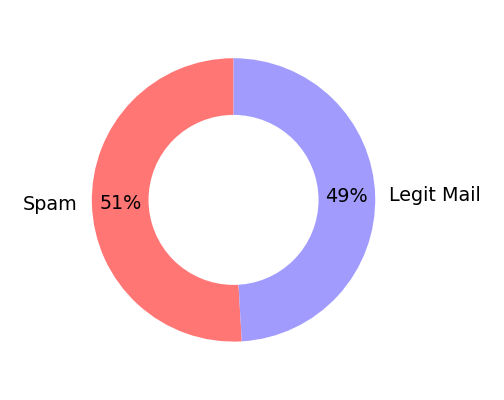

In [24]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#ff7675','#a29bfe']


plt.figure(figsize=(2,2), dpi = 230)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle = 90, autopct = '%1.0f%%', colors = custom_colors, pctdistance = 0.8)


#making a donut

centre_circle = plt.Circle((0,0), radius = 0.6, fc = 'white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing

## Download the NLTK Resources (Tokenizer & Stopwords)

In [25]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rachi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rachi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Functions for Email Processing

In [27]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
import pandas as pd

# Ensure required NLTK packages are downloaded
nltk.download('punkt', force=True)  # Force re-download to fix errors
nltk.download('stopwords')

# Initialize stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_msg_no_html(message):
    if pd.isna(message) or not isinstance(message, str) or message.strip() == "":
        return ["empty"]  # Prevent empty lists

    soup = BeautifulSoup(str(message), 'html.parser')  
    cleaned_text = soup.get_text()
    
    try:
        words = word_tokenize(cleaned_text.lower())  
    except LookupError:
        words = cleaned_text.lower().split()

    filtered_words = [stemmer.stem(word) for word in words if word.isalpha() and len(word) > 1 and word not in stop_words]

    return filtered_words if filtered_words else ["empty"]  # Prevent empty lists

# Load dataset (assuming CSV format)
data = pd.read_csv("C:/Users/rachi/OneDrive/Desktop/enron_spam_data.csv")  # Change file path as needed

# Check the available column names
print("Dataset Columns:", data.columns)

# Ensure correct column name for emails
email_column = "Message"  # Update if your column name is different

# Apply function to all emails while handling NaN values
data["Cleaned_Message"] = data[email_column].astype(str).fillna("").apply(clean_msg_no_html)

# Display first few cleaned emails
print(data[["Cleaned_Message"]].head())



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rachi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rachi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset Columns: Index(['Message ID', 'Subject', 'Message', 'Spam/Ham', 'Date'], dtype='object')
                                     Cleaned_Message
0                                              [nan]
1  [gari, product, high, island, larger, block, c...
2                    [calpin, daili, ga, nomin, doc]
3  [fyi, see, note, alreadi, done, stella, forwar...
4  [fyi, forward, lauri, allen, hou, ect, pm, kim...


# Apply Cleaning and Tokenization to all messages

## Slicing Dataframes and Series and Creating Subsets

In [28]:
%%time

#use apply() on all the messages in the dataframe
nested_list = data.Message.apply(clean_msg_no_html)

CPU times: total: 1min 16s
Wall time: 2min 24s


In [29]:
nested_list.head()

0                                              [empty]
1    [gari, product, high, island, larger, block, c...
2                      [calpin, daili, ga, nomin, doc]
3    [fyi, see, note, alreadi, done, stella, forwar...
4    [fyi, forward, lauri, allen, hou, ect, pm, kim...
Name: Message, dtype: object

In [30]:
nested_list.tail()

33711    [hello, welcom, gigapharm, onlinn, shop, presc...
33712    [got, earlier, expect, wrap, cautious, impress...
33713    [readi, rock, let, man, rise, solitud, show, u...
33714    [learn, last, time, longer, bed, read, plod, net]
33715    [hi, need, softwar, give, link, http, zk, net,...
Name: Message, dtype: object

## Using Logic to Slice Dataframes

In [31]:
doc_ids_spam = data[data["Spam/Ham"] == 1].index
doc_ids_ham = data[data["Spam/Ham"] == 0].index

## Subsetting a Series with an Index

In [32]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [33]:
nested_list_ham.shape

(16545,)

In [34]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [35]:
nested_list_spam.shape

(17171,)

In [36]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0]

37818

In [37]:
normal_words[:10]

enron      59783
ect        35324
hou        16945
compani    14683
pleas      13251
would      12509
com        12399
subject    12111
said       10833
market      9855
Name: count, dtype: int64

In [38]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0]

96058

In [39]:
spammy_words[:10]

compani      13879
com          11550
http          8758
inform        8726
email         8524
pleas         7619
secur         7426
price         7028
statement     6913
mail          6759
Name: count, dtype: int64

# Word Cloud of Ham and Spam Messages

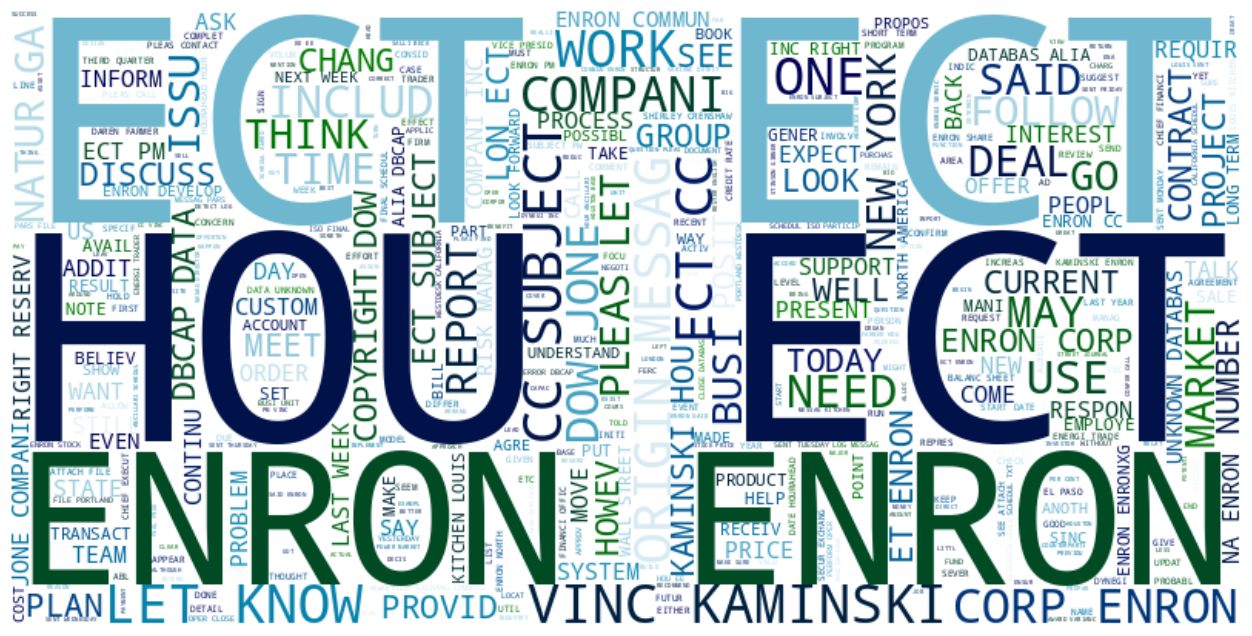

In [40]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# ✅ Generate text from ham messages
ham_str = ' '.join(flat_list_ham)

# ✅ Create a word cloud without a mask
word_cloud = WordCloud(
    background_color='white',
    max_words=500,
    colormap='ocean',
    max_font_size=200,
    width=800, height=400  # Define image size manually
)

word_cloud.generate(ham_str.upper())

# ✅ Display the word cloud
plt.figure(figsize=(16, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()


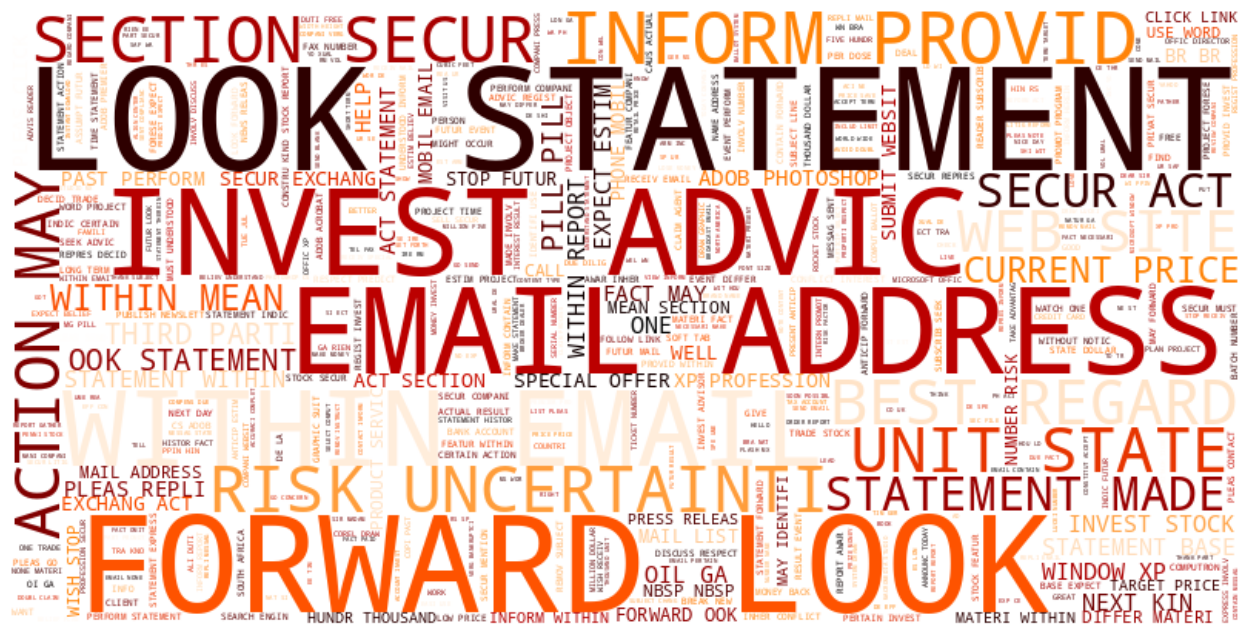

In [41]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# ✅ Generate text from spam messages
spam_str = ' '.join(flat_list_spam)

# ✅ Create a word cloud without a mask
word_cloud = WordCloud(
    background_color='white',
    max_words=2000,
    colormap='gist_heat',  # 🔥 Heatmap colors
    max_font_size=300,
    width=800, height=400  # Define manual size
)

word_cloud.generate(spam_str.upper())

# ✅ Display the word cloud
plt.figure(figsize=(16, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Generate Vocabulary & Dictionary

In [42]:
stemmed_nested_list = data.Message.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

In [43]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Number of unique words', unique_words.shape[0])
unique_words.head()

Number of unique words 116529


enron      59786
ect        35664
compani    28562
com        23949
pleas      20870
Name: count, dtype: int64

In [44]:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words: \n', frequent_words[:10])

Most common words: 
 enron      59786
ect        35664
compani    28562
com        23949
pleas      20870
hou        17264
time       15537
would      15461
price      15202
inform     14743
Name: count, dtype: int64


# Create Vocabulary DataFrame with a WORD_ID

In [45]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index = word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

VOCAB_WORD
WORD_ID           
0            enron
1              ect
2          compani
3              com
4            pleas

# Generate Features and a Sparse Matrix

## Creating a Dataframe with one word per column

In [46]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

0        1      2        3       4       5        6         7       8      \
0   empty     None   None     None    None    None     None      None    None   
1    gari  product   high   island  larger   block  commenc  saturday   gross   
2  calpin    daili     ga    nomin     doc    None     None      None    None   
3     fyi      see   note  alreadi    done  stella  forward    stella   morri   
4     fyi  forward  lauri    allen     hou     ect       pm  kimberli  vaughn   

   9      ... 20975 20976 20977 20978 20979 20980 20981 20982 20983 20984  
0   None  ...  None  None  None  None  None  None  None  None  None  None  
1  carlo  ...  None  None  None  None  None  None  None  None  None  None  
2   None  ...  None  None  None  None  None  None  None  None  None  None  
3    hou  ...  None  None  None  None  None  None  None  None  None  None  
4     pm  ...  None  None  None  None  None  None  None  None  None  None  

[5 rows x 20985 columns]

In [47]:
word_columns_df.shape

(33716, 20985)

## Splitting the Data into Training and Testing Dataset

In [48]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data["Spam/Ham"], test_size=0.3, random_state=42)

In [49]:
print('Number of training samples:', X_train.shape[0])
print('Fraction of training set:', X_train.shape[0]/word_columns_df.shape[0 ])

Number of training samples: 23601
Fraction of training set: 0.6999940680982323


In [50]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

0        1      2        3          4          5        6      \
DOC_ID                                                                  
8778      ian    sorri  delay  respond    current     london      fli   
21711   stock    watch  alert     morn      wysak  petroleum     wysk   
27046   think   breath    new     life       busi      start   revamp   
27617   hello    would   like    offer      local    softwar  version   
21898   great  softwar  great    price  microsoft     window       xp   

             7        8          9      ... 20975 20976 20977 20978 20979  \
DOC_ID                                  ...                                 
8778          back  houston   tomorrow  ...  None  None  None  None  None   
21711          key   energi     servic  ...  None  None  None  None  None   
27046        front      end       logo  ...  None  None  None  None  None   
27617       qerman   french    spanish  ...  None  None  None  None  None   
21898   profession       sp  microsoft  ...  None  None  None  None  None   

       20980 20981 20982 20983 20984  
DOC_ID                                
8778    None  None  None  None  None  
21711   None  None  None  None  None  
27046   None  None  None  None  None  
27617   None  None  None  None  None  
21898   None  None  None  None  None  

[5 rows x 20985 columns]

In [51]:
y_train.head()

8778     0
21711    1
27046    1
27617    1
21898    1
Name: Spam/Ham, dtype: int64

## Create a Sparse Matrix for the Training Data

In [59]:
word_index = pd.Index(vocab.VOCAB_WORD)
from scipy.sparse import coo_matrix

def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns a DataFrame in the format: LABEL, DOC_ID, OCCURRENCE, WORD_ID.
    
    df: A DataFrame with words in columns and document IDs as index (X_train or X_test)
    indexed_words: Index of words ordered by word ID
    labels: Category as a Series (y_train or y_test)
    """
    
    word_set = set(indexed_words)
    
    # Identify positions where words exist in vocab
    mask = df.map(lambda x: x in word_set)
    doc_ids, word_texts = np.where(mask.values)  # Get row & column indices
    
    # Get corresponding words
    words_found = df.values[doc_ids, word_texts]
    
    # Convert words to word indices
    word_ids = [indexed_words.get_loc(word) for word in words_found]
    
    # Map row indices to actual document IDs
    doc_indices = df.index[doc_ids]  # These should match X_train.index
    
    # Ensure labels align with doc_indices
    labels_mapped = labels.reindex(doc_indices).values  # Safe mapping
    
    # Create DataFrame with the expected columns
    sparse_df = pd.DataFrame({
        "LABEL": labels_mapped,
        "DOC_ID": doc_indices,
        "OCCURENCE": 1,  # Each word appears once per row
        "WORD_ID": word_ids
    })

    return sparse_df

In [60]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

CPU times: total: 2min 54s
Wall time: 3min 46s


In [61]:
sparse_train_df[:5]

LABEL  DOC_ID  OCCURENCE  WORD_ID
0      0    8778          1     1036
1      0    8778          1      942
2      0    8778          1      788
3      0    8778          1      103
4      0    8778          1      419

In [62]:
sparse_train_df.shape

(2487401, 4)

In [63]:
sparse_train_df[-5:]

LABEL  DOC_ID  OCCURENCE  WORD_ID
2487396      1   15795          1      214
2487397      1   15795          1      330
2487398      1   15795          1       61
2487399      1   15795          1      304
2487400      1   15795          1      275

# Combine Occurences with the Pandas groupby() Method

In [65]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      1756    0              1
1      0       0              1
       1       0             17
       4       0              2
       5       0             10

In [66]:
vocab.at[0,'VOCAB_WORD']

'enron'

In [67]:
train_grouped = train_grouped.reset_index()
train_grouped.head() 

DOC_ID  WORD_ID  LABEL  OCCURENCE
0       0     1756      0          1
1       1        0      0          1
2       1        1      0         17
3       1        4      0          2
4       1        5      0         10

In [68]:
train_grouped.tail()

DOC_ID  WORD_ID  LABEL  OCCURENCE
1376617   33715      490      1          1
1376618   33715      588      1          1
1376619   33715      632      1          1
1376620   33715     1114      1          1
1376621   33715     1512      1          1

In [69]:
vocab.at[1908, 'VOCAB_WORD']

'fl'

In [70]:
data.Message[5795]

"forum\njoe ,\ni would like to invite you to an off - site meeting of john griebling ' s\norganization\nand the research group .\ndate : april 27 - april 29\nlocation : breckenridge , colorado\nas you know , john griebling is managing the network design and construction\nproject\ncurrently under way in ebs . the research group is actively involved in this\neffort\nwhich requires advanced quantitative skills in the area of stochastic\noptimization and\nstochastic processes ( for modeling and forecasting internet traffic flows ) .\nthe objective of this meeting is to develop common language and accomplish\ntransfer\nof skills between the two groups , to facilitate cooperation on this project\nin the future .\nwe are inviting ken rice and kevin hannon to this meeting . we would\nappreciate if you could\nspeak , together with kevin and ken , on strategic directions of ebs . it is\nimportant for a group\nof technical people , with relatively specialized technical skills , to\nunderstand the

In [71]:
train_grouped.shape

(1376622, 4)

In [72]:
TRAINING_DATA_FILE="train-data.txt"
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

# Create a Sparse Matrix for the Test Data

In [73]:
X_test.head()

0      1       2         3       4        5       6        7      \
DOC_ID                                                                        
3820    discount    med   right      home  valium    xanax  weight   reduct   
3504      bammel   neon   group      fall     doc     None    None     None   
30823         yo  buddi  caught    action  obscen   footag   denis  richard   
22501    protect   part   reach      noon   sleep     tail    mani   silent   
29593       desk   vice  presid  luckyday    mail  lotteri  intern  program   

         8       9      ... 20975 20976 20977 20978 20979 20980 20981 20982  \
DOC_ID                  ...                                                   
3820      next     day  ...  None  None  None  None  None  None  None  None   
3504      None    None  ...  None  None  None  None  None  None  None  None   
30823     info    http  ...  None  None  None  None  None  None  None  None   
22501   observ   capit  ...  None  None  None  None  None  None  None  None   
29593   intern  promot  ...  None  None  None  None  None  None  None  None   

       20983 20984  
DOC_ID              
3820    None  None  
3504    None  None  
30823   None  None  
22501   None  None  
29593   None  None  

[5 rows x 20985 columns]

In [74]:
y_test.head()

3820     1
3504     0
30823    1
22501    1
29593    1
Name: Spam/Ham, dtype: int64

In [75]:
X_test.shape

(10115, 20985)

In [76]:
%%time

sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: total: 1min 9s
Wall time: 1min 58s


In [77]:
sparse_test_df.shape

(1075893, 4)

In [79]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

DOC_ID  WORD_ID  LABEL  OCCURENCE
0       3        1      0         18
1       3        5      0         10
2       3       12      0          3
3       3       18      0          1
4       3       24      0          1

In [80]:
test_grouped.shape

(589487, 4)

In [81]:
TEST_DATA_FILE="test-data.txt"
np.savetxt(TEST_DATA_FILE, test_grouped, fmt = '%d')